<a href="https://colab.research.google.com/github/Tstrebe2/umich-mads-capstone-project/blob/main/tim-ft-densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install pydicom -q

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

#path = '/content/drive/MyDrive/SIADS_699_Capstone/Capstone_Team_Project' #Google Drive path
path = '/home/ausgear' #Great Lakes
data_path = os.path.join(path, 'data/rsna-pneumonia')
img_path = os.path.join(data_path, 'stage_2_train_images')
viz_path = os.path.join(path, 'visualizations')

In [4]:
import pandas as pd

annotations_file = os.path.join(data_path, 'stage_2_train_labels.csv')
label_df = pd.read_csv(annotations_file)
pneum_df = label_df[label_df['Target']==1]
display(pneum_df.head())

patient_ids = pneum_df['patientId'].unique().tolist()
num_patients = len(patient_ids)

print(num_patients)

record_dict = pneum_df.to_dict(orient='index')

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


6012


In [65]:
import pydicom as dicom
from PIL import Image
import matplotlib.pyplot as plt

def read_img(p_id):
    img_file = os.path.join(img_path, p_id + '.dcm')
    dcm_img = dicom.dcmread(img_file)
    img_arr = dcm_img.pixel_array
    return img_arr

def display_img(img_arr):
    plt.imshow(img_arr, cmap=plt.cm.bone)
    return None

def color_img(img, color):
    img = img.convert('RGBA')
    # Split into 3 channels
    r, g, b, a = img.split()
    if color == 'red':
        g = g.point(lambda x: 0)
        b = b.point(lambda x: 0)
    elif color == 'green':
        r = r.point(lambda x: 0)
        b = b.point(lambda x: 0)
    elif color == 'blue':
        r = r.point(lambda x: 0)
        g = g.point(lambda x: 0)
    else:
        print('Not an option')
    img = Image.merge('RGBA', (r, g, b, a))
    return img

def max_ratio(img):
    hi = img.max()
    return hi / 254

def torch_img(img):
    img = img.astype(np.uint8)
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    return img

def avg_img(accum_img, num):
    img = np.copy(accum_img)
    img = img / num_patients
    img = torch_img(img)
    return img

def scale_img(accum_img):
    img = np.copy(accum_img)
    ratio = max_ratio(img)
    img = img / ratio
    img = torch_img(img)
    return img

def log_img(accum_img):
    img = np.copy(accum_img)
    img = np.log(img)
    ratio = max_ratio(img)
    img = img / ratio
    img = torch_img(img)
    return img

def power_img(accum_img, power):
    img = np.copy(accum_img)
    ratio = max_ratio(img)
    img = img / ratio
    img = img**power
    ratio = max_ratio(img)
    img = img / ratio
    img = torch_img(img)
    return img

In [19]:
#This is for creating BB distribution
import numpy as np
from datetime import datetime
import torch
import torchvision

accum_bb = np.zeros((1024,1024))

for idx, (k, v) in enumerate(record_dict.items()):

    x_min = int(v['x'])
    x_max = int(v['x'] + v['width'])
    y_min = int(v['y'])
    y_max = int(v['y'] + v['height'])
    accum_bb[y_min:y_max,x_min:x_max] += 255

    #if idx % 500 == 0:
        #print(f'idx: {idx}, percent: {(idx + 1)/len(patient_ids)} time: {datetime.now()}')

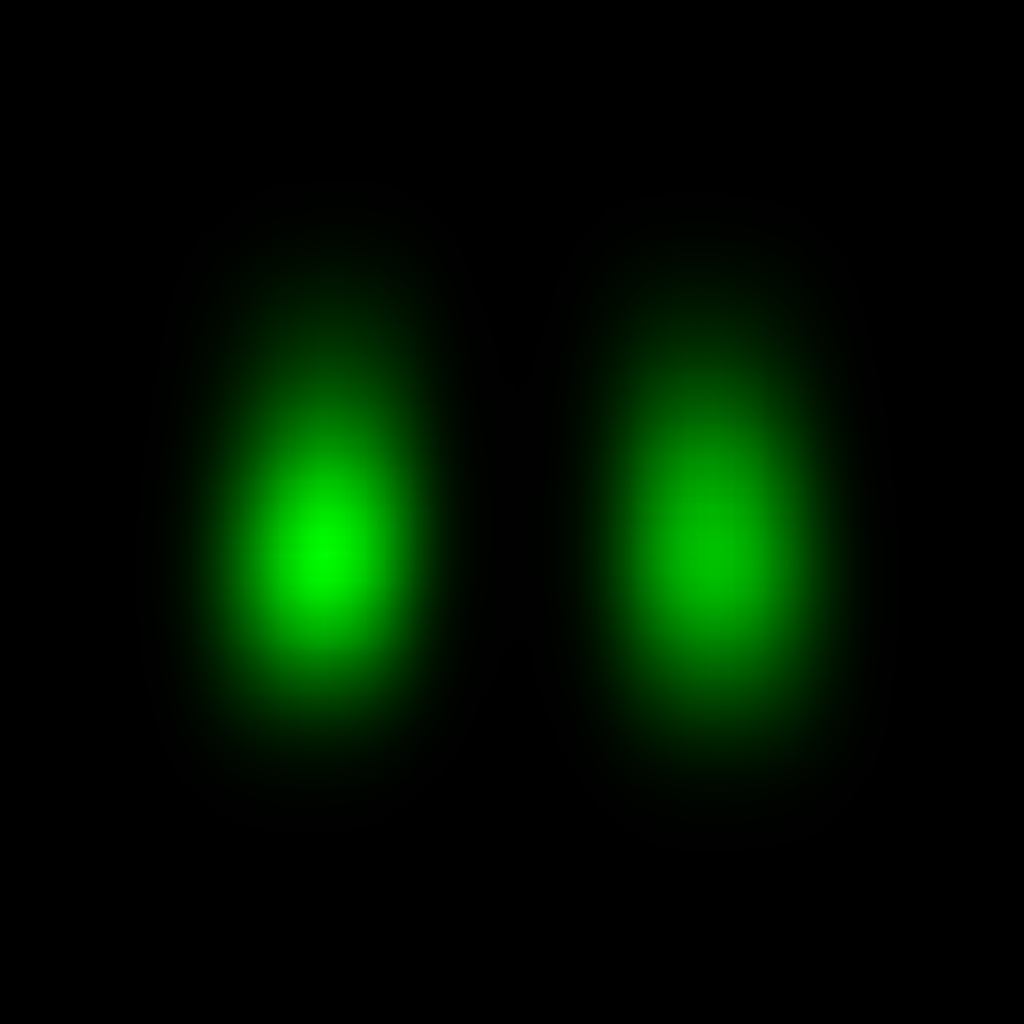

In [66]:
img = power_img(accum_bb, 3)
bb_pow = torchvision.transforms.ToPILImage()(img)
bb_pow = color_img(bb_pow, 'green')
bb_pow

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime

accum_chest = np.zeros((1024,1024))

for idx, p_id in enumerate(patient_ids):

    img_arr = read_img(p_id)
    accum_chest += img_arr
    
    #if idx % 500 == 0:
        #print(f'idx: {idx}, percent: {(idx + 1)/len(patient_ids)} time: {datetime.now()}')

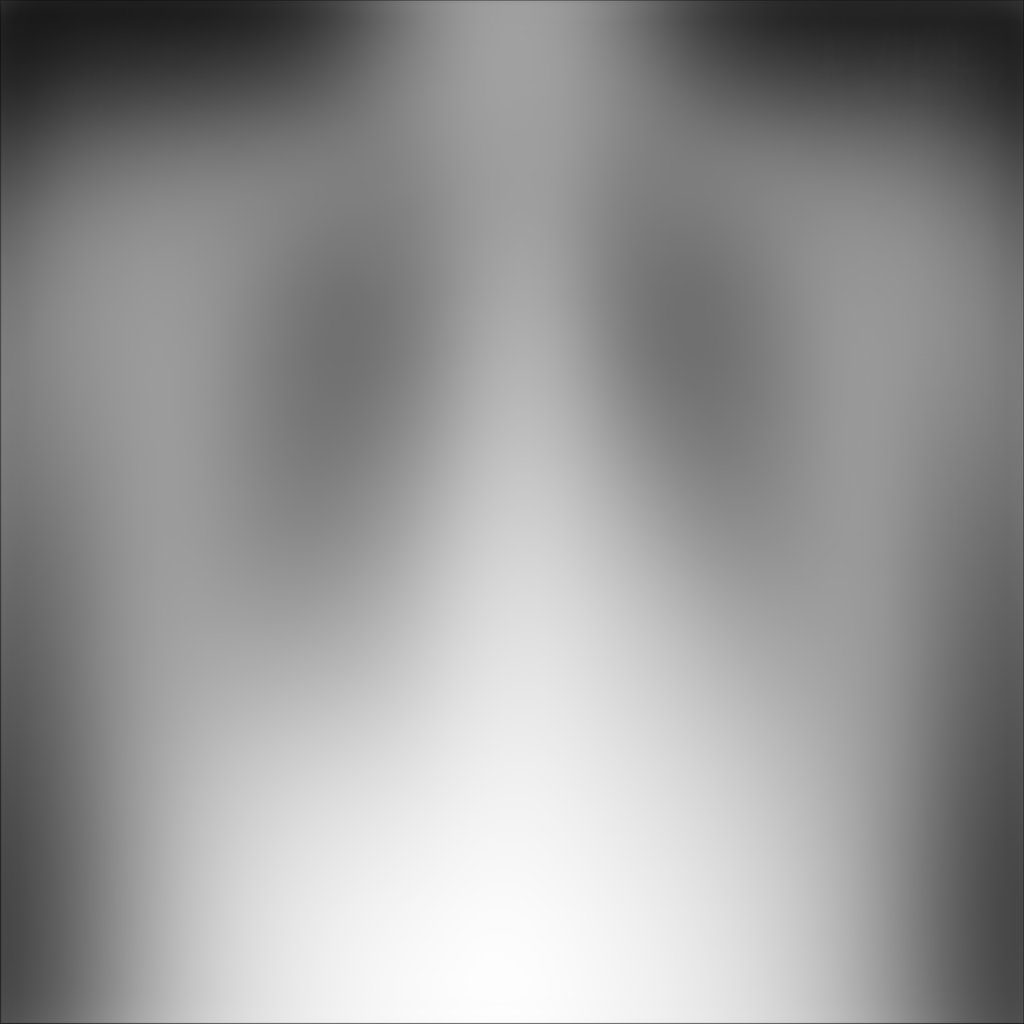

In [67]:
img = power_img(accum_chest, 1)
chest_pow = torchvision.transforms.ToPILImage()(img)
chest_pow

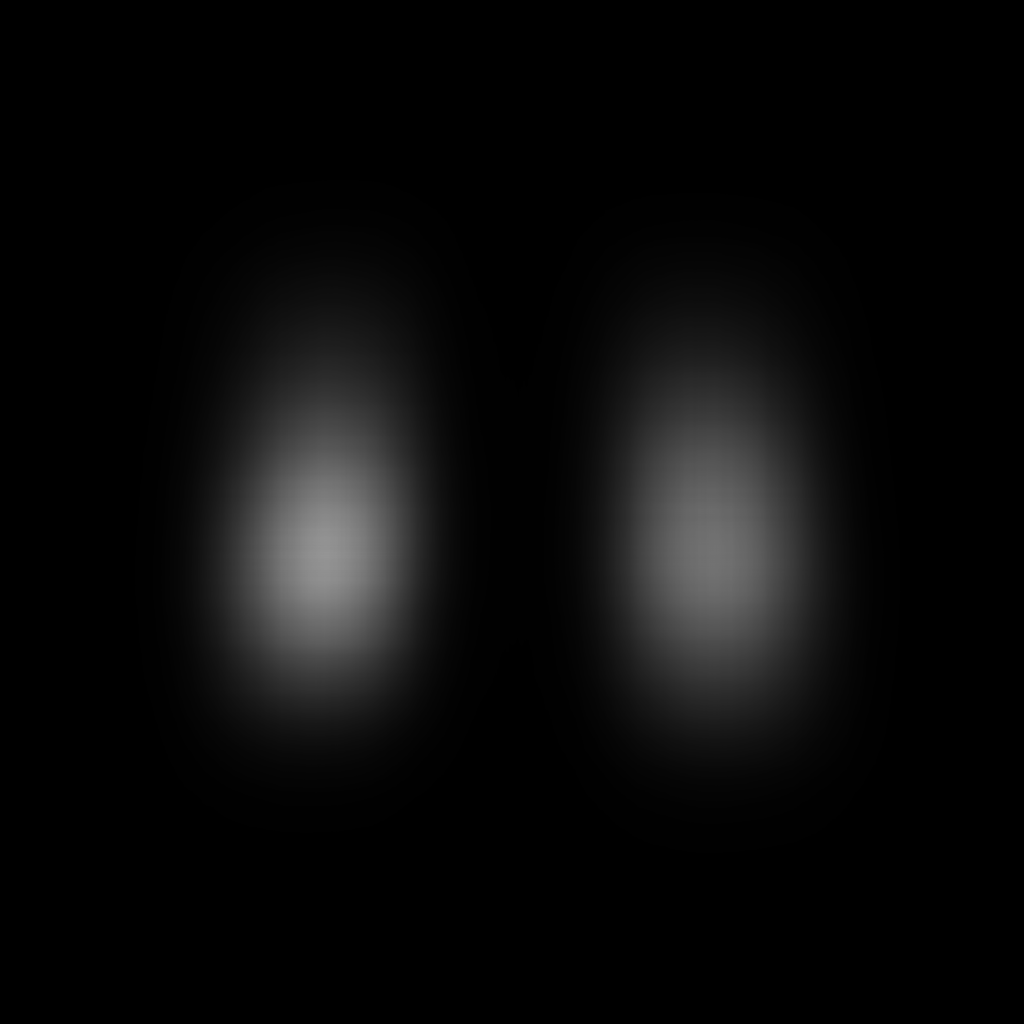

In [68]:
chest_pow.paste(bb_pow, (0,0), mask = bb_pow)
chest_pow